# Inference on Real Quantum Backend with SamplerV2

This notebook is reworked for **inference only** using **SamplerV2** to support dynamic circuits on real quantum backends.

Key differences from the training notebook:
- Uses **SamplerQNN** instead of EstimatorQNN (supports dynamic circuits with resets)
- Loads pre-trained model directly from `output/inference_model.pkl`
- No training - inference only
- Compatible with IBM Quantum real backends

In [1]:
import numpy as np
import os
from qiskit.visualization.circuit_visualization import circuit_drawer
from qiskit_aer import Aer, AerSimulator
import pickle
import time
from qiskit import transpile
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# custom functions
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..', 'src')))
from utils import *
from prebuilt_cicuits import circuit_3x4_8in_2out

Configuration Variables

In [2]:
use_adap_pool = True  # Keep True - SamplerQNN supports dynamic circuits
num_test = 250  # 250 for sim 10 for real backend (250 takes 5 minutes on real backend)
noise_scale_on_images = 0.5  # Noise level for test images
seed = 3333
algorithm_globals.random_seed = seed
model_path = "../model_weights/inference_model.pkl"
use_real_quantum_backend = False  # Set to True for real IBM quantum hardware

Build Quantum Circuit

Circuit has 8 qubits, 8 classical bits
Input params: 12, Weight params: 94


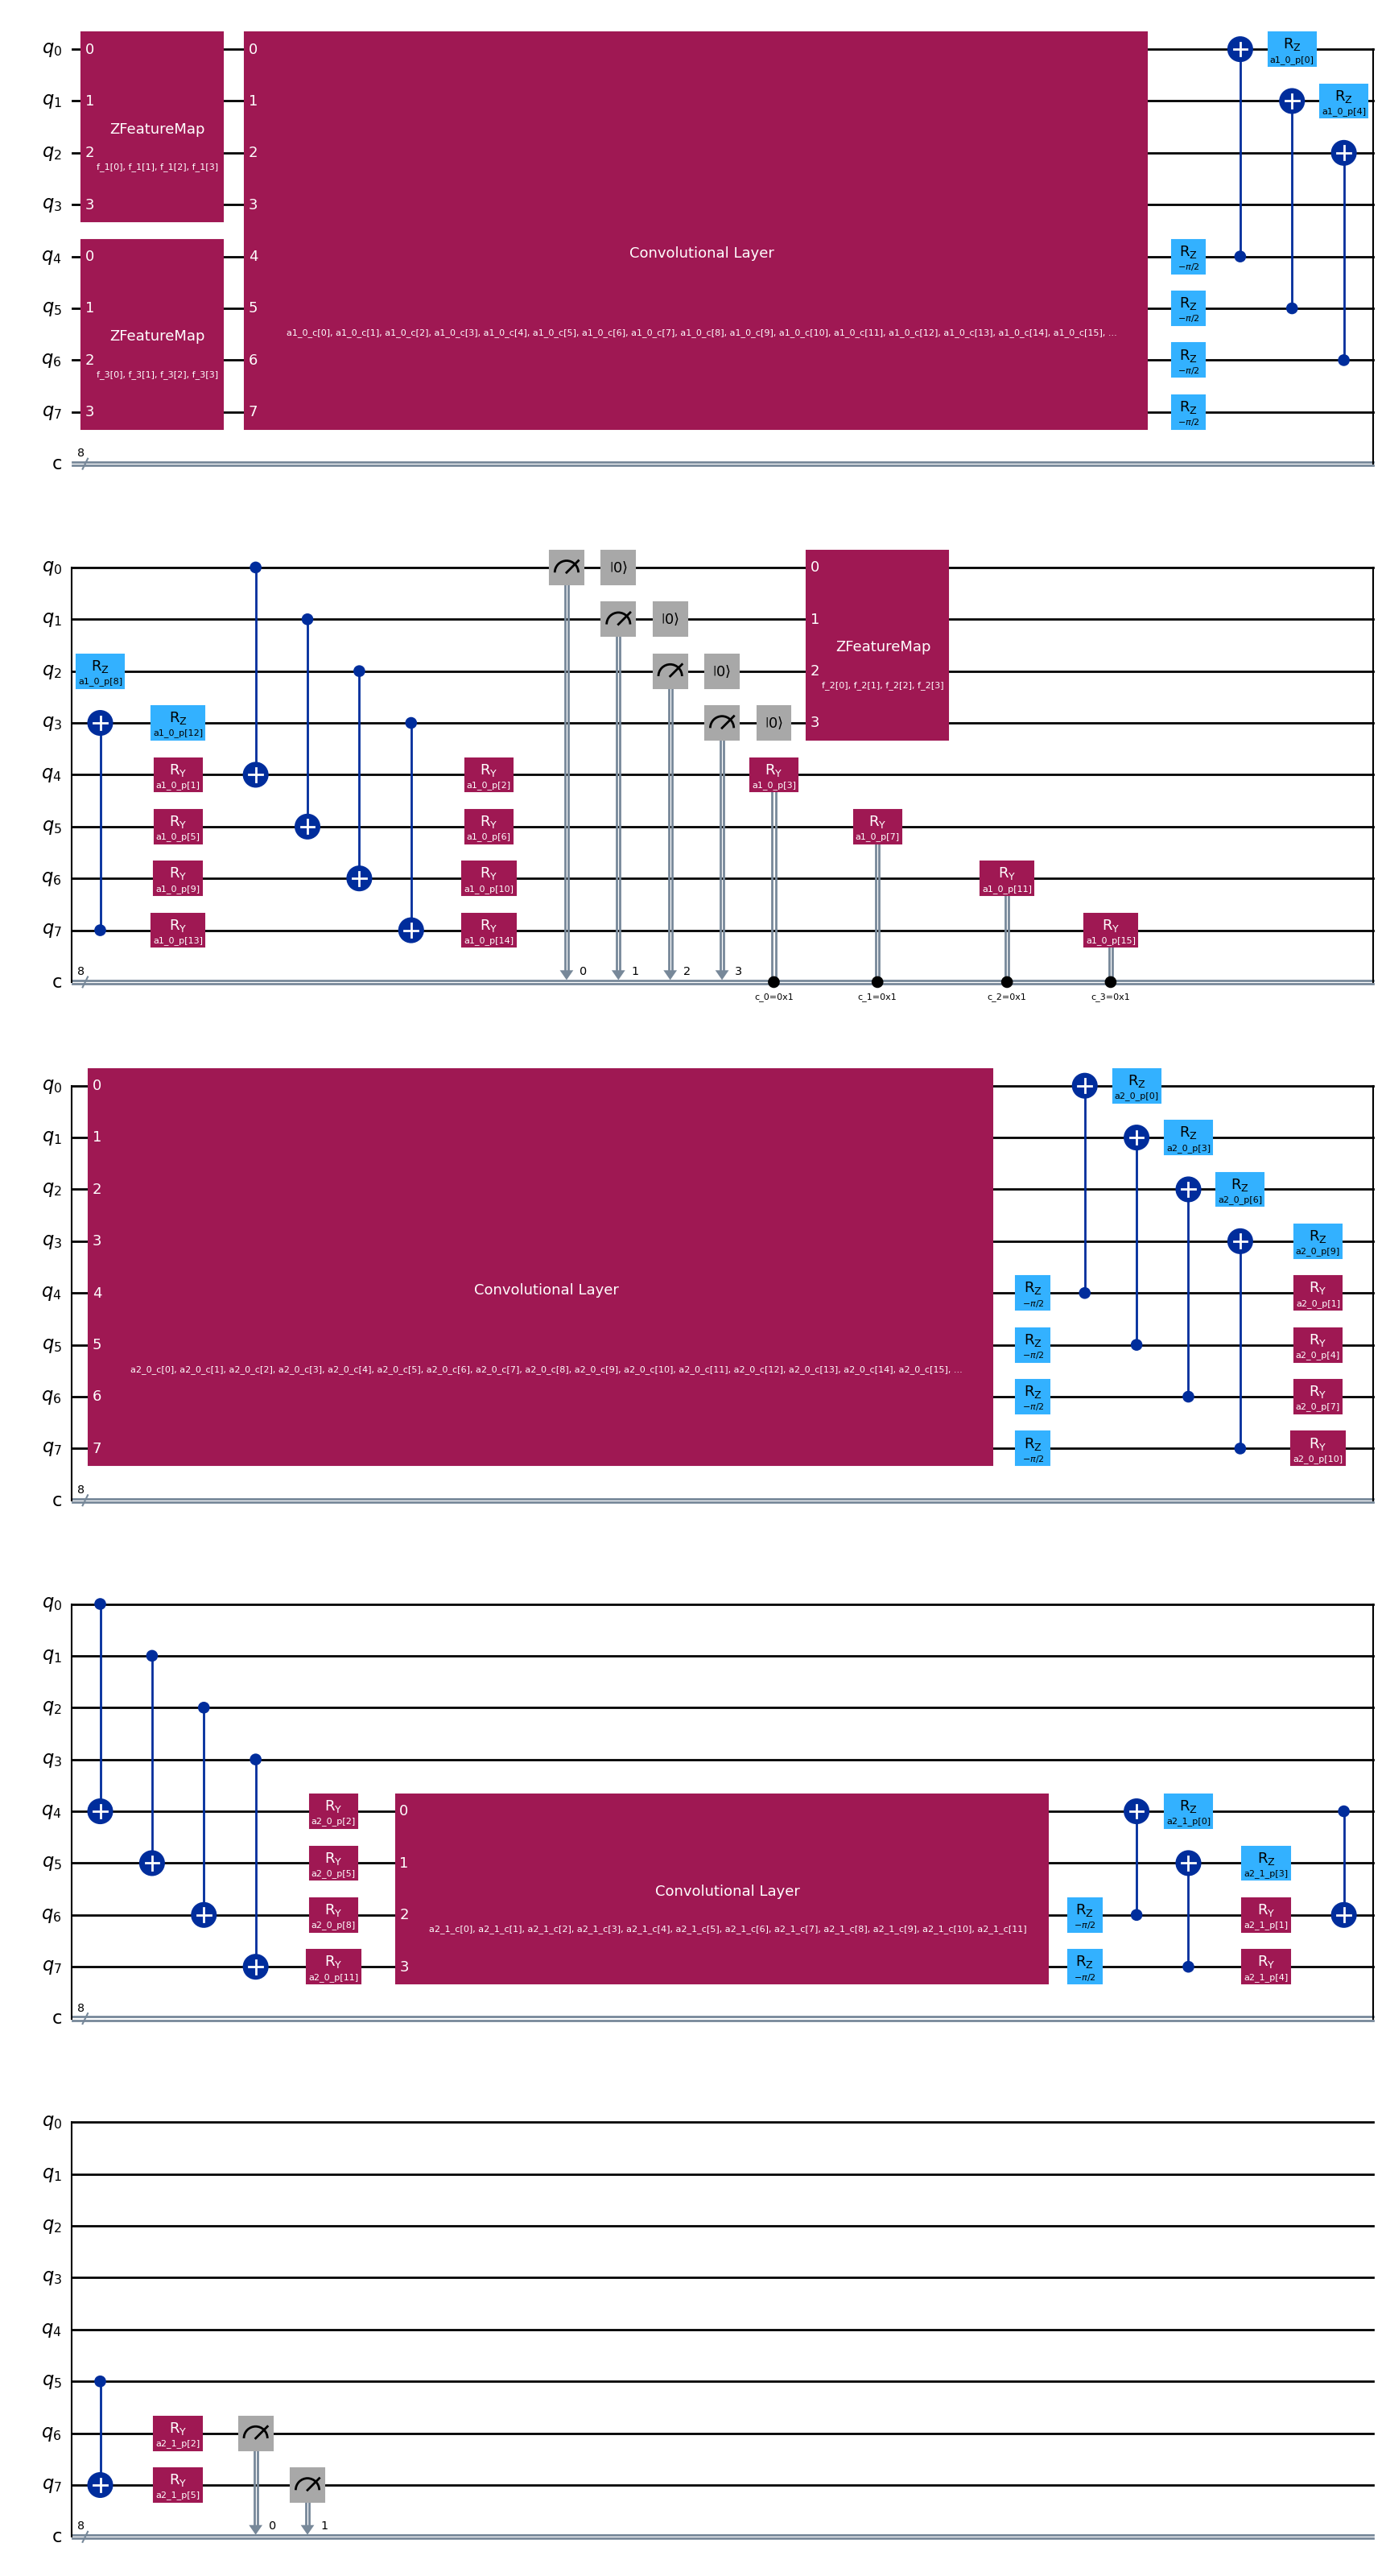

In [3]:
full_circuit, input_params, weight_params, observable = circuit_3x4_8in_2out(
    use_adap_pool=use_adap_pool,
    return_params=True
)

# Measure the final 2 qubits (qubits 6 and 7) to match ZZ observable
full_circuit.measure([6, 7], [0, 1])

print(f"Circuit has {full_circuit.num_qubits} qubits, {full_circuit.num_clbits} classical bits")
print(f"Input params: {len(input_params)}, Weight params: {len(weight_params)}")
full_circuit.draw(output="mpl")

Setup Backend (Simulator or Real Quantum Hardware)

In [4]:
backend = None

if use_real_quantum_backend:
    # Connect to IBM Quantum
    token = os.getenv("IBM_QUANTUM_TOKEN")
    if not token: raise ValueError("IBM_QUANTUM_TOKEN environment variable not set! Run: $env:IBM_QUANTUM_TOKEN='your_token'")
    service = QiskitRuntimeService(channel="ibm_cloud", token=token)
    
    # List available backends
    backends = service.backends(operational=True, simulator=False)
    print("Available backends:")
    for b in backends:
        print(f"  - {b.name}")
    
    # Get the least busy backend (or specify one manually)
    backend = service.least_busy(operational=True, simulator=False)
    print(f"\nUsing backend - {backend.name}")
else:
    # Use local simulator
    backend = AerSimulator(
        method='statevector',
        device='CPU',
        max_parallel_threads=0
    )
    print(f"Using AerSimulator on {backend.options.device}")

Using AerSimulator on CPU


In [5]:
# Transpile the circuit for the backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(full_circuit)
print(f"After transpile: depth={isa_circuit.depth()}, gates={isa_circuit.size()}")

# Create the sampler with the backend
sampler = Sampler(mode=backend)

# ZZ correlation function to match EstimatorQNN behavior
def zz_correlation(x):
    """
    Interpret measurement results to match ZZ observable behavior.
    ZZ measures correlation between last two qubits (measured to classical bits 0 and 1).
    Returns 1 if qubits are the same (00 or 11), 0 if different (01 or 10).
    This matches ZZ observable: +1 for same, -1 for different.
    """
    # x can be either an integer (if classical register > measured bits) or a bitstring
    if isinstance(x, int):
        # x is an integer representing the full classical register
        # Extract bits 0 and 1 (LSB)
        bit_0 = x & 1        # Bit 0 (LSB)
        bit_1 = (x >> 1) & 1 # Bit 1
    else:
        # x is a bitstring (when classical register size = number of measurements)
        bit_0 = int(x[0])
        bit_1 = int(x[1])
    
    # Return 1 if same (ZZ = +1), 0 if different (ZZ = -1)
    return 1 if bit_0 == bit_1 else 0

# Create the QNN with the sampler
qnn = SamplerQNN(
    circuit=isa_circuit,
    input_params=input_params,
    weight_params=weight_params,
    sampler=sampler,
    interpret=zz_correlation,  # Map measurement outcomes to match ZZ observable
    output_shape=2     # Binary classification: [prob(different), prob(same)]
)

print(f"QNN created with {len(qnn.input_params)} input params and {len(qnn.weight_params)} weight params")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


After transpile: depth=58, gates=252
QNN created with 12 input params and 94 weight params


Generate Test Dataset

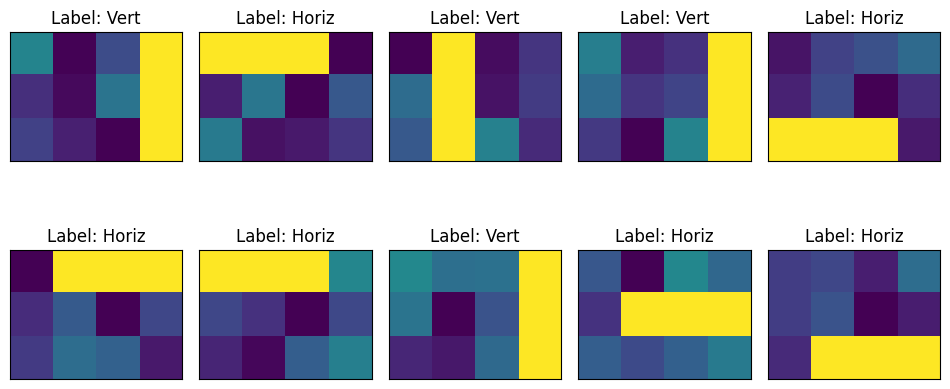

Generated 250 test images


In [6]:
n = 3; m = 4; stripe_len = 3
test_images, test_labels = generate_dataset(num_test, noise_scale=noise_scale_on_images, n=n, m=m, 
                                            stripe_length=stripe_len, seed=seed+2)

# Plot some examples from the test set
fig, ax = plt.subplots(2, 5, figsize=(12, 5), subplot_kw={"xticks": [], "yticks": []})
for i in range(min(10, num_test)):
    ax[i // 5, i % 5].imshow(
        np.array(test_images[i]).reshape(n, m),
        aspect="equal",
    )
    ax[i // 5, i % 5].set_title(f"Label: {'Horiz' if test_labels[i] == -1 else 'Vert'}")
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

print(f"Generated {num_test} test images")

Load Pre-trained Model Weights

In [7]:
# Load the trained model weights
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

with open(model_path, 'rb') as f:
    trained_params = pickle.load(f)

weights = trained_params['weights']
print(f"Loaded model weights: {len(weights)} parameters")
print(f"Model info:")
print(f"  - Best val accuracy: {trained_params.get('best_val_accuracy', 'N/A')}")
print(f"  - Best extended val accuracy: {trained_params.get('best_extended_val_accuracy', 'N/A')}")

Loaded model weights: 94 parameters
Model info:
  - Best val accuracy: N/A
  - Best extended val accuracy: N/A


Run Inference on Test Images

In [8]:
x = np.asarray(test_images)
y = np.asarray(test_labels)

print(f"Running inference on {len(x)} test images...")
if use_real_quantum_backend:
    print("This will take time due to queue wait and execution on real hardware!")
    
start_time = time.time()

# Forward pass through QNN with loaded weights
raw = qnn.forward(x, weights)

elapsed = time.time() - start_time
print(f"Inference completed in {elapsed:.2f} seconds ({elapsed/len(x):.2f}s per image)")

# Convert raw outputs to class labels
# SamplerQNN with zz_correlation returns probabilities for [different(0), same(1)]
# This matches ZZ observable: output[0]=prob(ZZ=-1), output[1]=prob(ZZ=+1)
raw = np.asarray(raw).reshape(-1, 2)  # Shape: (n_samples, 2)
prob_same = raw[:, 1]  # Probability that last 2 qubits are same (ZZ = +1)
prob_diff = raw[:, 0]  # Probability that last 2 qubits are different (ZZ = -1)

# Compute expectation value of ZZ: E[ZZ] = prob(same) * (+1) + prob(diff) * (-1)
zz_expectation = prob_same - prob_diff

# Convert to {-1, +1} labels based on sign of ZZ expectation
# Positive ZZ -> +1, Negative ZZ -> -1
y_predict = np.where(zz_expectation >= 0, 1, -1)

# Compute accuracy
acc = float(np.mean(y_predict == y))
print(f"\nAccuracy on test data: {np.round(100 * acc, 2)}%")

# Save raw results for later analysis
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
backend_name = backend.name if hasattr(backend, 'name') else 'simulator'

# Create output directory if it doesn't exist
os.makedirs("output", exist_ok=True)
results_filename = f"output/inference_results_{backend_name}_{timestamp}.pkl"

inference_results = {
    'raw_output': raw,  # Raw probabilities from QNN
    'prob_same': prob_same,
    'prob_diff': prob_diff,
    'zz_expectation': zz_expectation,
    'predictions': y_predict,
    'true_labels': y,
    'test_images': test_images,
    'accuracy': acc,
    'elapsed_time': elapsed,
    'backend': backend_name,
    'num_test': num_test,
    'timestamp': timestamp,
    'use_real_quantum_backend': use_real_quantum_backend,
}

with open(results_filename, 'wb') as f:
    pickle.dump(inference_results, f)

print(f"\n✓ Results saved to: {results_filename}")

Running inference on 250 test images...
Inference completed in 13.60 seconds (0.05s per image)

Accuracy on test data: 95.2%

✓ Results saved to: output/inference_results_aer_simulator_statevector_20251104_190902.pkl
Inference completed in 13.60 seconds (0.05s per image)

Accuracy on test data: 95.2%

✓ Results saved to: output/inference_results_aer_simulator_statevector_20251104_190902.pkl


Visualize Results

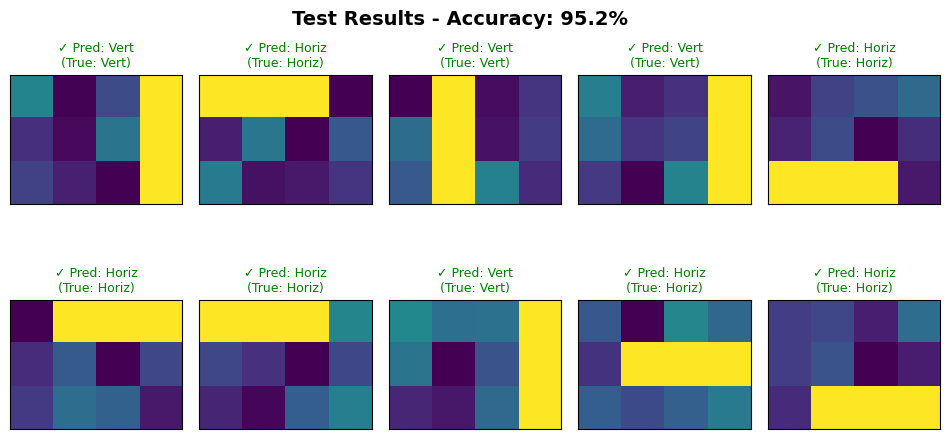


Detailed Results:
--------------------------------------------------
Image 1: Predicted=+1, True=+1, ZZ=+0.025 - ✓ CORRECT
Image 2: Predicted=-1, True=-1, ZZ=-0.164 - ✓ CORRECT
Image 3: Predicted=+1, True=+1, ZZ=+0.152 - ✓ CORRECT
Image 4: Predicted=+1, True=+1, ZZ=+0.070 - ✓ CORRECT
Image 5: Predicted=-1, True=-1, ZZ=-0.270 - ✓ CORRECT
Image 6: Predicted=-1, True=-1, ZZ=-0.158 - ✓ CORRECT
Image 7: Predicted=-1, True=-1, ZZ=-0.336 - ✓ CORRECT
Image 8: Predicted=+1, True=+1, ZZ=+0.068 - ✓ CORRECT
Image 9: Predicted=-1, True=-1, ZZ=-0.016 - ✓ CORRECT
Image 10: Predicted=-1, True=-1, ZZ=-0.508 - ✓ CORRECT
Image 11: Predicted=+1, True=+1, ZZ=+0.148 - ✓ CORRECT
Image 12: Predicted=+1, True=+1, ZZ=+0.117 - ✓ CORRECT
Image 13: Predicted=+1, True=+1, ZZ=+0.135 - ✓ CORRECT
Image 14: Predicted=+1, True=-1, ZZ=+0.057 - ✗ WRONG
Image 15: Predicted=+1, True=+1, ZZ=+0.098 - ✓ CORRECT
Image 16: Predicted=-1, True=-1, ZZ=-0.408 - ✓ CORRECT
Image 17: Predicted=-1, True=-1, ZZ=-0.477 - ✓ CORRECT
Image 

In [9]:
# Visualize predictions
num_display = min(10, len(test_images))
fig, ax = plt.subplots(2, 5, figsize=(12, 5), subplot_kw={"xticks": [], "yticks": []})

for i in range(num_display):
    row, col = i // 5, i % 5
    ax[row, col].imshow(test_images[i].reshape(3, 4), aspect="equal")
    
    # Check if prediction is correct
    correct = "✓" if y_predict[i] == y[i] else "✗"
    pred_label = "Horiz" if y_predict[i] == -1 else "Vert"
    true_label = "Horiz" if y[i] == -1 else "Vert"
    
    color = "green" if y_predict[i] == y[i] else "red"
    
    ax[row, col].set_title(
        f"{correct} Pred: {pred_label}\n(True: {true_label})",
        fontsize=9,
        color=color
    )

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.suptitle(f"Test Results - Accuracy: {np.round(100 * acc, 2)}%", fontsize=14, fontweight='bold')
plt.show()

# Print detailed results
print("\nDetailed Results:")
print("-" * 50)
for i in range(len(test_images)):
    status = "✓ CORRECT" if y_predict[i] == y[i] else "✗ WRONG"
    print(f"Image {i+1}: Predicted={y_predict[i]:+d}, True={y[i]:+d}, ZZ={zz_expectation[i]:+.3f} - {status}")

Optional: Reload and Re-analyze Saved Results

In [10]:
# Example: Load previously saved results
results_file = results_filename
#results_file = "output\\inference_results_250.pkl"  # Change to your file
with open(results_file, 'rb') as f:
    loaded_results = pickle.load(f)
# Extract data
raw = loaded_results['raw_output']
prob_same = loaded_results['prob_same']
prob_diff = loaded_results['prob_diff']
zz_expectation = loaded_results['zz_expectation']
y_predict = loaded_results['predictions']
y = loaded_results['true_labels']
test_images = loaded_results['test_images']
acc = loaded_results['accuracy']
print(f"Loaded results from: {results_file}")
print(f"Backend: {loaded_results['backend']}")
print(f"Timestamp: {loaded_results['timestamp']}")
print(f"Accuracy: {np.round(100 * acc, 2)}%")
print(f"Execution time: {loaded_results['elapsed_time']:.2f}s")
# Now you can re-run visualization or try different prediction logic

Loaded results from: output/inference_results_aer_simulator_statevector_20251104_190902.pkl
Backend: aer_simulator_statevector
Timestamp: 20251104_190902
Accuracy: 95.2%
Execution time: 13.60s
